# Fraud Detection on Transactions
<hr>

In [9]:
# import functions
import sys
import os 
sys.path.append('../src')

from preprocessing import count_unique_numbers, generalize_categories

In [10]:
# Import General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.pipeline import make_pipeline

# Import libraries for model building
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import RandomizedSearchCV

# Summary

Through this project, we attempted to build three classification models capable of distinguishing between fraud and non-fraud transactions, as indicated on customer accounts. The models we experimented with include logistic regression, random forest classifier, and gradient boost classifier. Due to an extreme imbalance in our data, we encountered challenges in developing an effective model in Milestone 1. The results of our experimented models are listed below. 

|                       | Logistic Regression    | Random Forest Classifier        |  Gradient Boost Classifier        |
| :-------------        | -----------------------: | -----------------------: | -----------------------: |
| **Train f1 Score** | 0.00623         | 0.0783              | 0.872 |
| **Test f1 Score**    | 0.00612         |   0.0732      | 0.0386                  |

To enhance the `f1` scores, we have provided suggestions in the discussion section. Potential improvements include incorporating frequency encoding through feature engineering, adjusting scoring metrics, and experimenting with more complex models. 

# Introduction

In recent times, credit card fraud has emerged as one of the most prevalent forms of fraudulent activities. According to [The Ascent](https://www.fool.com/the-ascent/research/identity-theft-credit-card-fraud-statistics/) the incidence of credit card fraud has seen a significant rise, escalating from 371,000 reports in 2017 to 1.4 million in 2021. To combat this surge in credit card fraud, corporations have turned to machine learning algorithms, employing them to automatically detect and filter fraudulent transactions. These models are trained on historical data to identify potential fraud.

This project is driven by the goal of constructing an effective fraud detection model to mitigate the occurrence of credit card frauds. The [Capital One Data Science Challenge](https://github.com/CapitalOneRecruiting/DS) dataset is utilized for building our model, consisting of 786,363 entries of synthetically generated data. Since all the data is synthetically generated, we ensure that customer confidentiality is maintained throughout the model-building process. 

# Methods & Results

## Read Dataset (Web)

In [7]:
# Imports to download dataset from 
# import json
# from zipfile import ZipFile
# from io import BytesIO
# from urllib.request import urlopen

# Download Function

In [1]:
url = "https://github.com/CapitalOneRecruiting/DS/blob/173ca4399629f1e4e74146107eb9bef1e7009741/transactions.zip?raw=true"

In [2]:
import requests

def download_file_from_url(url, file_path):
    '''
    Download a file from a capital one fraud detection url

    :param url: URL of the file 
    :param file_path: Path where the file
    '''
    response = requests.get(url)
    if response.status_code == 200:
        with open(file_path, 'wb') as file:
            file.write(response.content)
        print("downloaded Successfully.")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")


file_path = "../data/transactions.zip"
download_file_from_url(url, file_path)


downloaded Successfully.


# read function 

In [3]:
import pandas as pd

def read_csv_from_zip(zip_file_path):
    '''
    Reads a CSV file from a zip archive into a pandas DataFrame.

    :param zip_file_path: The path to the zip file containing the CSV.
    :return: A pandas DataFrame containing the data from the CSV file.
    '''
    try:
        df = pd.read_csv(zip_file_path)
        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


zip_file_path = '../data/transactions.zip'
raw_df = read_csv_from_zip(zip_file_path)



In [4]:
#resp = urlopen(url)
#myzip = ZipFile(BytesIO(resp.read()))

#data_list = []

#for line in myzip.open(myzip.namelist()[0]).readlines():
#    data_list.append(json.loads(line))
#df = pd.DataFrame(data_list)

In [5]:
# Saving raw_data to data folder
raw_df.to_pickle('../data/transactions.pkl.zip', compression='zip')

## Read Dataset (Local)

In [6]:
df = pd.read_pickle('../data/transactions.pkl.zip', compression="infer")

# EDA Analysis 

## 1. Basic Information Dataset Overview

In [7]:
df.head()

,"{""accountNumber"": ""737265056""","""customerId"": ""737265056""","""creditLimit"": 5000.0","""availableMoney"": 5000.0","""transactionDateTime"": ""2016-08-13T14:27:32""","""transactionAmount"": 98.55","""merchantName"": ""Uber""","""acqCountry"": ""US""","""merchantCountryCode"": ""US""","""posEntryMode"": ""02""",...,"""echoBuffer"": """"","""currentBalance"": 0.0","""merchantCity"": """"","""merchantState"": """"","""merchantZip"": """"","""cardPresent"": false","""posOnPremises"": """"","""recurringAuthInd"": """"","""expirationDateKeyInMatch"": false","""isFraud"": false}"
0,"{""accountNumber"": ""737265056""","""customerId"": ""737265056""","""creditLimit"": 5000.0","""availableMoney"": 5000.0","""transactionDateTime"": ""2016-10-11T05:05:54""","""transactionAmount"": 74.51","""merchantName"": ""AMC #191138""","""acqCountry"": ""US""","""merchantCountryCode"": ""US""","""posEntryMode"": ""09""",...,"""transactionType"": ""PURCHASE""","""echoBuffer"": """"","""currentBalance"": 0.0","""merchantCity"": """"","""merchantState"": """"","""merchantZip"": """"","""posOnPremises"": """"","""recurringAuthInd"": """"","""expirationDateKeyInMatch"": false","""isFraud"": false}"
1,"{""accountNumber"": ""737265056""","""customerId"": ""737265056""","""creditLimit"": 5000.0","""availableMoney"": 5000.0","""transactionDateTime"": ""2016-11-08T09:18:39""","""transactionAmount"": 7.47","""merchantName"": ""Play Store""","""acqCountry"": ""US""","""merchantCountryCode"": ""US""","""posEntryMode"": ""09""",...,"""echoBuffer"": """"","""currentBalance"": 0.0","""merchantCity"": """"","""merchantState"": """"","""merchantZip"": """"","""cardPresent"": false","""posOnPremises"": """"","""recurringAuthInd"": """"","""expirationDateKeyInMatch"": false","""isFraud"": false}"
2,"{""accountNumber"": ""737265056""","""customerId"": ""737265056""","""creditLimit"": 5000.0","""availableMoney"": 5000.0","""transactionDateTime"": ""2016-12-10T02:14:50""","""transactionAmount"": 7.47","""merchantName"": ""Play Store""","""acqCountry"": ""US""","""merchantCountryCode"": ""US""","""posEntryMode"": ""09""",...,"""echoBuffer"": """"","""currentBalance"": 0.0","""merchantCity"": """"","""merchantState"": """"","""merchantZip"": """"","""cardPresent"": false","""posOnPremises"": """"","""recurringAuthInd"": """"","""expirationDateKeyInMatch"": false","""isFraud"": false}"
3,"{""accountNumber"": ""830329091""","""customerId"": ""830329091""","""creditLimit"": 5000.0","""availableMoney"": 5000.0","""transactionDateTime"": ""2016-03-24T21:04:46""","""transactionAmount"": 71.18","""merchantName"": ""Tim Hortons #947751""","""acqCountry"": ""US""","""merchantCountryCode"": ""US""","""posEntryMode"": ""02""",...,"""transactionType"": ""PURCHASE""","""echoBuffer"": """"","""currentBalance"": 0.0","""merchantCity"": """"","""merchantState"": """"","""merchantZip"": """"","""posOnPremises"": """"","""recurringAuthInd"": """"","""expirationDateKeyInMatch"": false","""isFraud"": false}"
4,"{""accountNumber"": ""830329091""","""customerId"": ""830329091""","""creditLimit"": 5000.0","""availableMoney"": 5000.0","""transactionDateTime"": ""2016-04-19T16:24:27""","""transactionAmount"": 30.76","""merchantName"": ""In-N-Out #422833""","""acqCountry"": ""US""","""merchantCountryCode"": ""US""","""posEntryMode"": ""02""",...,"""transactionType"": ""PURCHASE""","""echoBuffer"": """"","""currentBalance"": 0.0","""merchantCity"": """"","""merchantState"": """"","""merchantZip"": """"","""posOnPremises"": """"","""recurringAuthInd"": """"","""expirationDateKeyInMatch"": false","""isFraud"": false}"


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786362 entries, 0 to 786361
Data columns (total 29 columns):
 #   Column                                         Non-Null Count   Dtype 
---  ------                                         --------------   ----- 
 0   {"accountNumber": "737265056"                  786362 non-null  object
 1    "customerId": "737265056"                     786362 non-null  object
 2    "creditLimit": 5000.0                         786362 non-null  object
 3    "availableMoney": 5000.0                      786362 non-null  object
 4    "transactionDateTime": "2016-08-13T14:27:32"  786362 non-null  object
 5    "transactionAmount": 98.55                    786362 non-null  object
 6    "merchantName": "Uber"                        786362 non-null  object
 7    "acqCountry": "US"                            786362 non-null  object
 8    "merchantCountryCode": "US"                   786362 non-null  object
 9    "posEntryMode": "02"                          7

## 2. Descriptive Statistics

In [9]:
df.describe()

,"{""accountNumber"": ""737265056""","""customerId"": ""737265056""","""creditLimit"": 5000.0","""availableMoney"": 5000.0","""transactionDateTime"": ""2016-08-13T14:27:32""","""transactionAmount"": 98.55","""merchantName"": ""Uber""","""acqCountry"": ""US""","""merchantCountryCode"": ""US""","""posEntryMode"": ""02""",...,"""echoBuffer"": """"","""currentBalance"": 0.0","""merchantCity"": """"","""merchantState"": """"","""merchantZip"": """"","""cardPresent"": false","""posOnPremises"": """"","""recurringAuthInd"": """"","""expirationDateKeyInMatch"": false","""isFraud"": false}"
count,786362,786362,786362,786362,786362,786362,786362,786362,786362,786362,...,786362,786362,786362,786362,786362,786362,786362,786362,786362,786362
unique,5000,5000,10,521916,520959,762642,67848,2500,17,28,...,4588,10,10,8,9,9,9,4,4,4
top,"{""accountNumber"": ""380680241""","""customerId"": ""380680241""","""creditLimit"": 5000.0","""availableMoney"": 250.0","""currentBalance"": 8.46","""merchantName"": ""Apple iTunes""","""merchantName"": ""Uber""","""acqCountry"": ""US""","""acqCountry"": ""US""","""merchantCountryCode"": ""US""",...,"""transactionType"": ""PURCHASE""","""echoBuffer"": """"","""merchantCity"": """"","""merchantState"": """"","""merchantZip"": """"","""cardPresent"": false","""posOnPremises"": """"","""recurringAuthInd"": """"","""expirationDateKeyInMatch"": false","""isFraud"": false}"
freq,32850,32850,201862,6015,26,36,1690,53113,720610,720606,...,396456,399608,423752,423752,423752,424202,772245,772245,772245,773945


## 3. Data Cleaning and Preprocessing Missing Values

In [7]:
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])
missing_values

Series([], dtype: int64)


accountNumber               0
customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
echoBuffer                  0
currentBalance              0
merchantCity                0
merchantState               0
merchantZip                 0
cardPresent                 0
posOnPremises               0
recurringAuthInd            0
expirationDateKeyInMatch    0
isFraud                     0
dtype: int64

In [8]:
def count_empty_strings(column):
    return (column == '').sum()

# Apply this function to each column
empty_string_counts = df.apply(count_empty_strings)
print(empty_string_counts)

accountNumber                    0
customerId                       0
creditLimit                      0
availableMoney                   0
transactionDateTime              0
transactionAmount                0
merchantName                     0
acqCountry                    4562
merchantCountryCode            724
posEntryMode                  4054
posConditionCode               409
merchantCategoryCode             0
currentExpDate                   0
accountOpenDate                  0
dateOfLastAddressChange          0
cardCVV                          0
enteredCVV                       0
cardLast4Digits                  0
transactionType                698
echoBuffer                  786363
currentBalance                   0
merchantCity                786363
merchantState               786363
merchantZip                 786363
cardPresent                      0
posOnPremises               786363
recurringAuthInd            786363
expirationDateKeyInMatch         0
isFraud             

### 3.1 Drop columns with mostly empty strings(count > 70,000)

In [9]:
df.drop(['echoBuffer', 'merchantCity', 'merchantZip', 'posOnPremises', 'recurringAuthInd' ,'merchantState'], axis=1, inplace=True)


In [10]:
df.head(5)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,False,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,True,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,True,False,False


# 4. Data Preprocessing, Data Type Conversion, Cat encoding, missing value imputing

In [11]:
# Convert dates to datetime for plotting
df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])

# 5. Data Visualization 

## 5.1 Numerical & Categorical Features visuals

numerical features
Index(['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance'], dtype='object')
categorical_features
Index(['accountNumber', 'customerId', 'merchantName', 'acqCountry',
       'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'cardPresent', 'expirationDateKeyInMatch',
       'isFraud'],
      dtype='object')


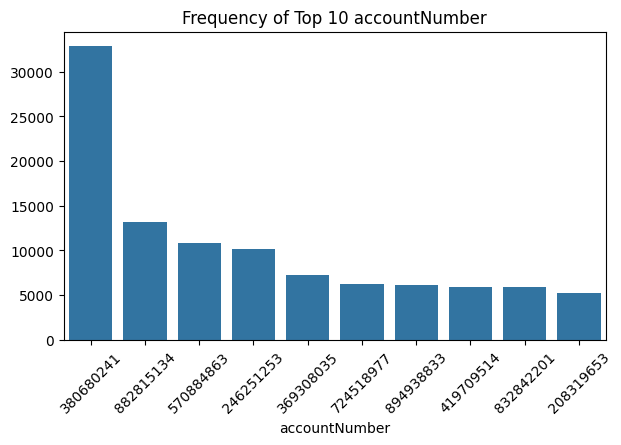

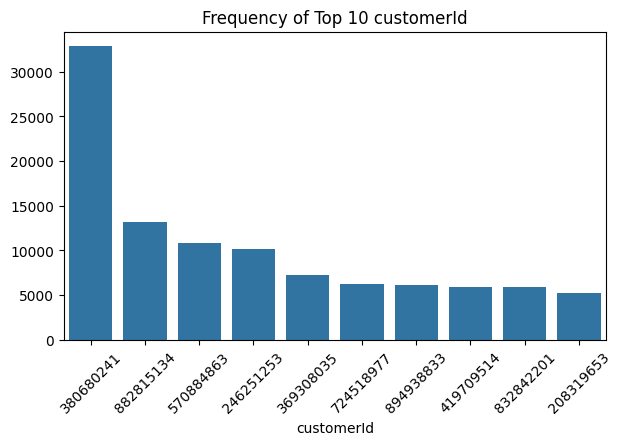

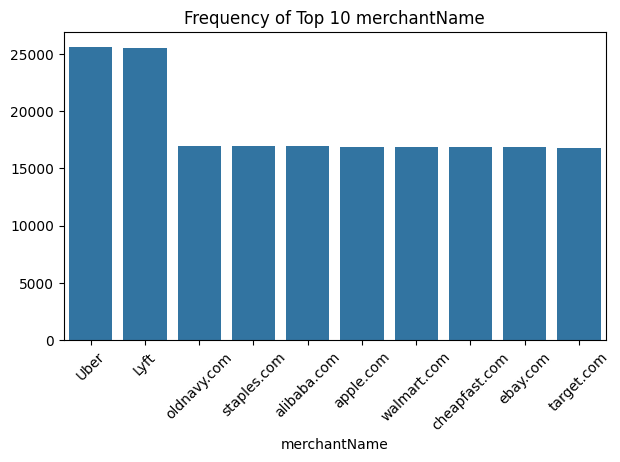

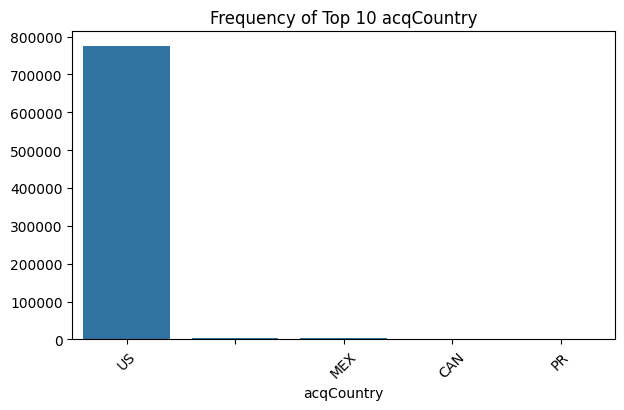

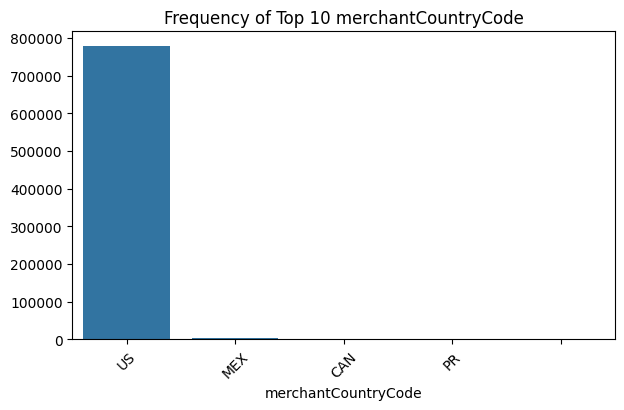

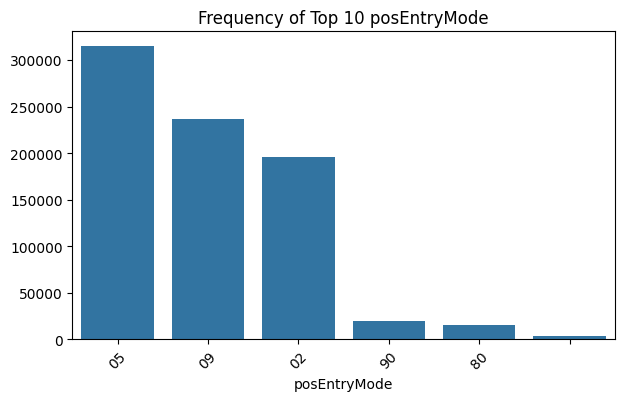

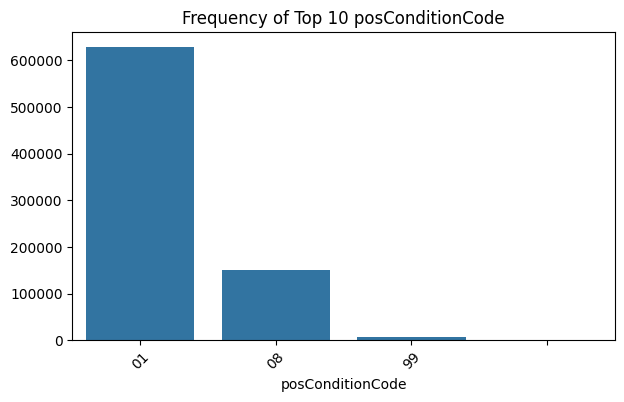

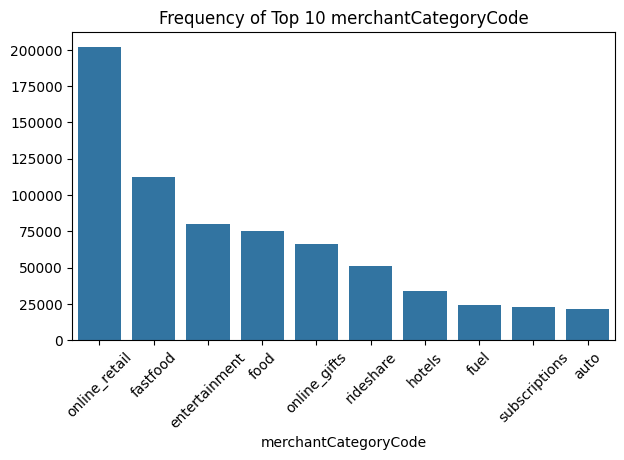

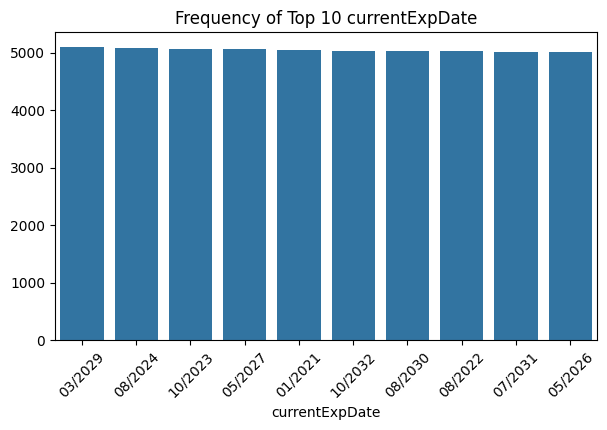

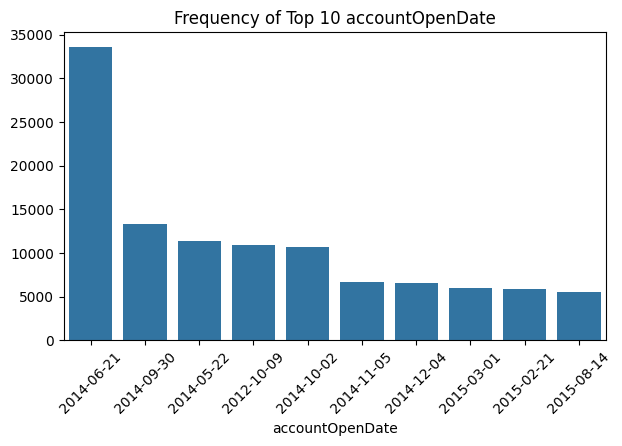

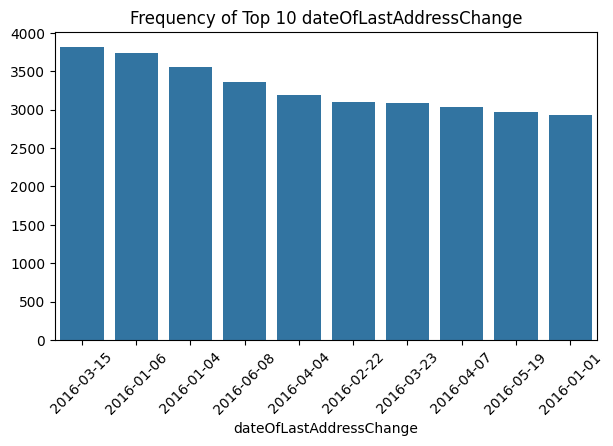

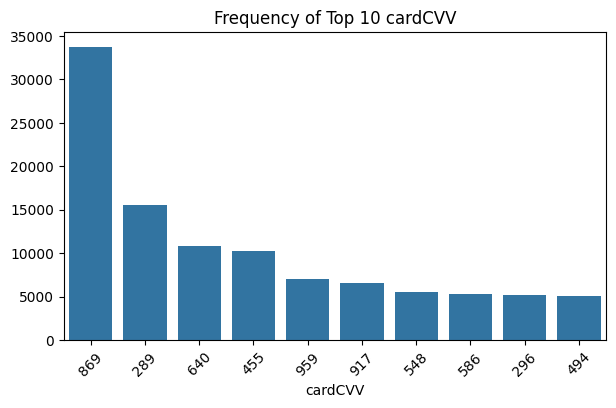

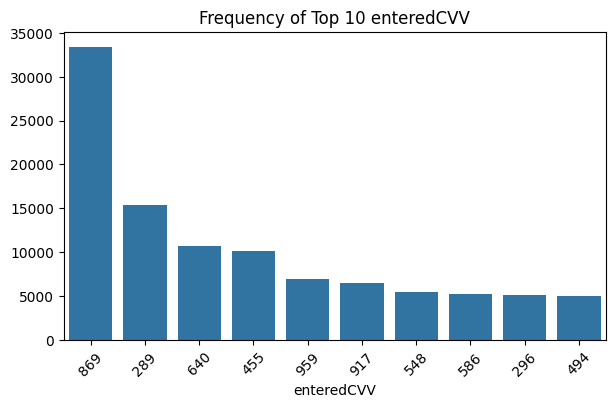

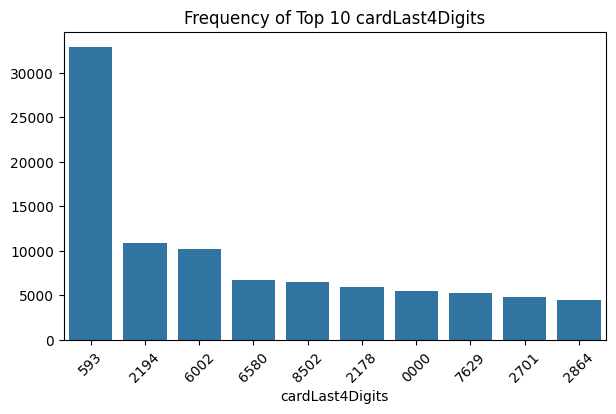

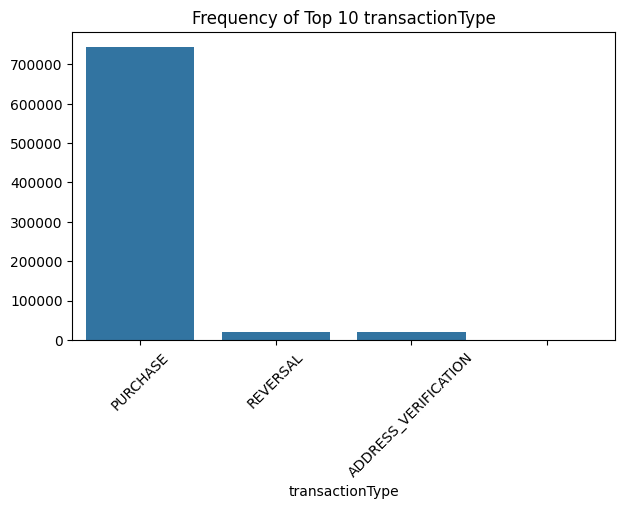

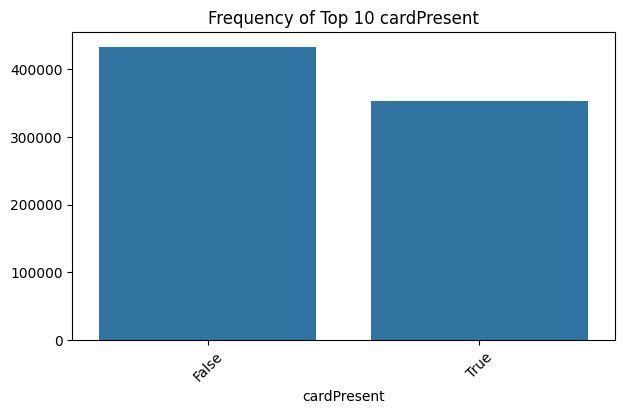

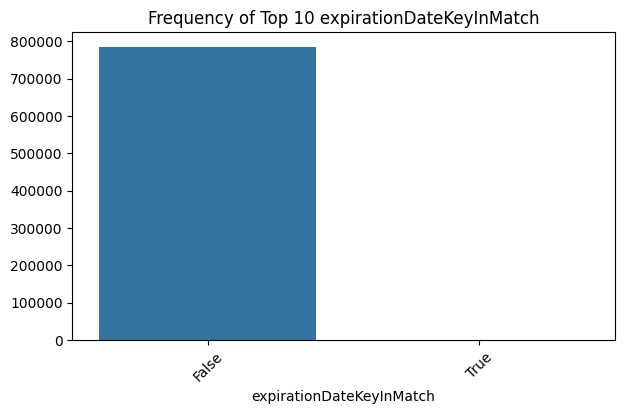

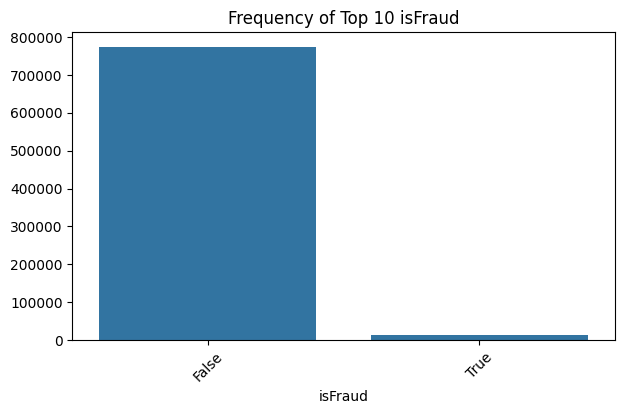

In [12]:
# 1. Histograms for Numerical Features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
print('numerical features')
print(numerical_features)
categorical_features = df.select_dtypes(include=['object', 'bool']).columns
print('categorical_features')
print( categorical_features)

# 2. Bar Charts for Categorical Features
for col in categorical_features:
    counts = df[col].value_counts().nlargest(10)  # Taking the top 10 for brevity
    plt.figure(figsize=(7,4))
    sns.barplot(x=counts.index, y=counts.values)
    plt.title(f'Frequency of Top 10 {col}')
    plt.xticks(rotation=45)
    plt.show()

## 5.2 Outlier Detection with boxplots

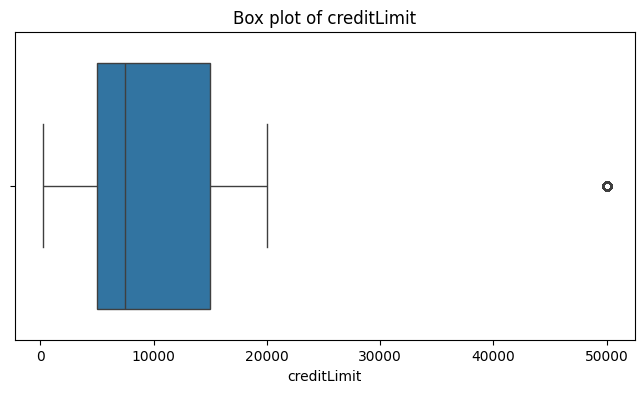

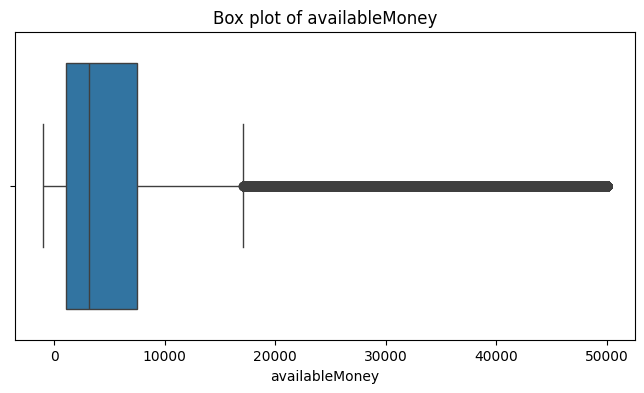

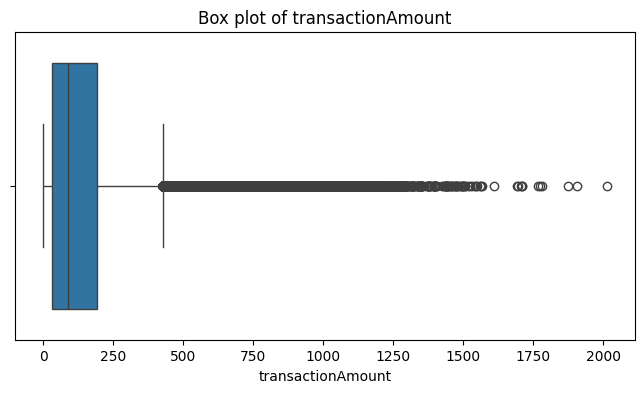

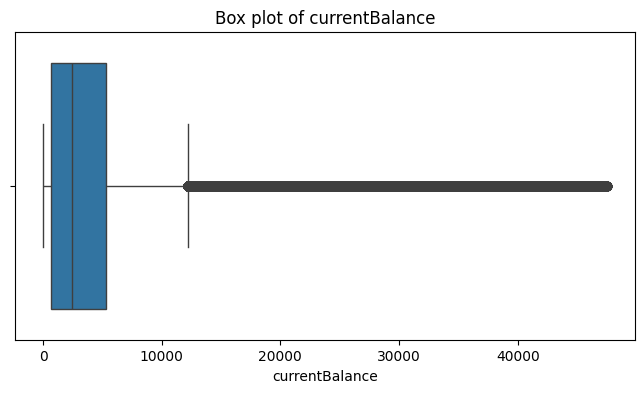

In [13]:
# 3. Box Plots for Numerical Features
for col in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x=col)
    plt.title(f'Box plot of {col}')
    plt.show()

## 5.3 Time Series Analysis

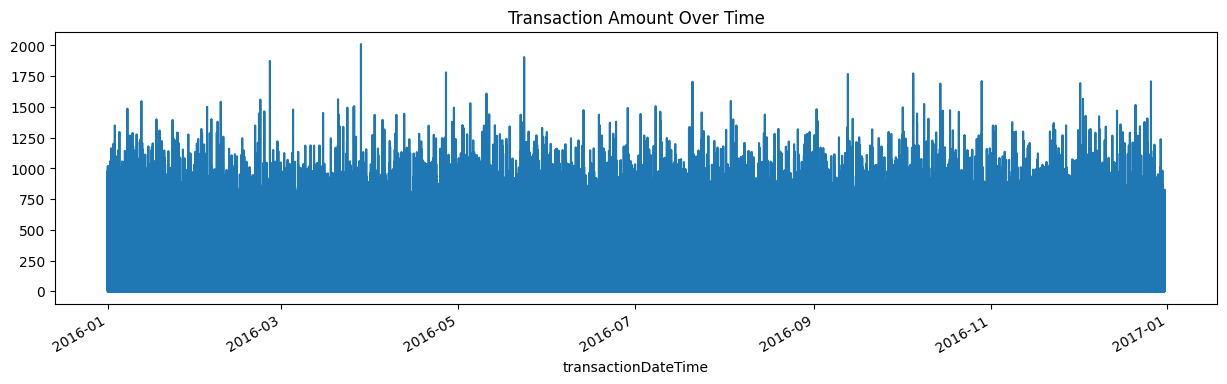

In [14]:
# 4. Time Series Plot
plt.figure(figsize=(15, 4))
df.set_index('transactionDateTime')['transactionAmount'].plot()
plt.title('Transaction Amount Over Time')
plt.show()

## 5.4 Correlation Analysis for Numerical Features


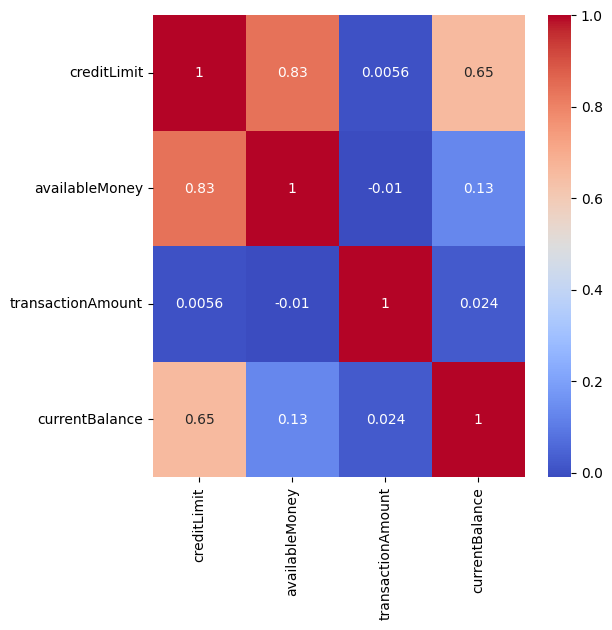

In [15]:
plt.figure(figsize=(6, 6))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm')
plt.show()


# 6 Feature Engineering

We created a cvv matched feature to check if the entered cvv for the purchase is the same as card cvv

In [16]:
numerical_features = numerical_features.tolist()
categorical_features = categorical_features.tolist()

In [17]:
df["CVVmatched"] = df.cardCVV == df.enteredCVV
df = df.drop(["cardCVV", "enteredCVV"], axis=1)
categorical_features.remove("cardCVV")
categorical_features.remove("enteredCVV")
categorical_features.append("CVVmatched")

# 7 Preprocessing

In [18]:
display(df.head())
print("Number of columns:",len(df.columns.tolist()))
print("Number of numeric feature columns:",len(numerical_features))
print("Number of categorical feature columns:",len(categorical_features))

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,CVVmatched
0,737265056,737265056,5000.0,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,...,06/2023,2015-03-14,2015-03-14,1803,PURCHASE,0.0,False,False,False,True
1,737265056,737265056,5000.0,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,...,02/2024,2015-03-14,2015-03-14,767,PURCHASE,0.0,True,False,False,True
2,737265056,737265056,5000.0,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,...,08/2025,2015-03-14,2015-03-14,767,PURCHASE,0.0,False,False,False,True
3,737265056,737265056,5000.0,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,...,08/2025,2015-03-14,2015-03-14,767,PURCHASE,0.0,False,False,False,True
4,830329091,830329091,5000.0,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,...,10/2029,2015-08-06,2015-08-06,3143,PURCHASE,0.0,True,False,False,True


Number of columns: 22
Number of numeric feature columns: 4
Number of categorical feature columns: 17


In [19]:
len(df["transactionDateTime"].unique().tolist())

776637

We have included all columns as our features except for `transactionDateTime`, which is a `datetime` column. As seen from the above, the number of unique values in `transactionDateTime` is 776637; thus, this will be dropped.

In [20]:
drop_features = ["transactionDateTime"]

In [21]:
categorical_features.remove("isFraud")

In [22]:
# Account number and customer id columns are redundant.
print((df.accountNumber == df.customerId).all())
df = df.drop("customerId", axis=1)
categorical_features.remove("customerId")

True


In [23]:
# We decided to drop merchantName column because it vastly increased our feature space. 
# Without adding much information. merchantCategoryCode will be used to categorize merchants.
df = df.drop("merchantName", axis=1)
categorical_features.remove("merchantName")

In [24]:
df = df.drop(["accountOpenDate", 'cardLast4Digits'], axis=1)
categorical_features.remove("accountOpenDate")
categorical_features.remove("cardLast4Digits")

`isFraud` is our target variable, hence removed from `categorical_features` list.

In [25]:
print(f"Numerical Features: {numerical_features}\n")
print(f"Categorical Features: {categorical_features}")

Numerical Features: ['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance']

Categorical Features: ['accountNumber', 'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'merchantCategoryCode', 'currentExpDate', 'dateOfLastAddressChange', 'transactionType', 'cardPresent', 'expirationDateKeyInMatch', 'CVVmatched']


### 7.1 Preprocessing Categorical Features

In [26]:
# Using imported function from src/preprocessing.py
count_unique_numbers(df, categorical_features)

,feature,unique_entry_counts
0,accountNumber,5000
7,dateOfLastAddressChange,2184
6,currentExpDate,165
5,merchantCategoryCode,19
3,posEntryMode,6
1,acqCountry,5
2,merchantCountryCode,5
4,posConditionCode,4
8,transactionType,4
9,cardPresent,2


We have seen way too many unique entries for a few categorical features, including `accountNumber` and `customerId`. Thus we will apply a function to narrow down the number of unique entries; once the number of unique entries in a column is **greater than 10**, `generalize_categories` function will classify entries that appear less than 10% in our dataset as "Others". 

In [27]:
# Using imported function from src/preprocessing.py
preprocess_df = df.copy()
for category_column in categorical_features:
    preprocess_df[category_column] = preprocess_df[category_column].replace('', 'Other')
    if len(preprocess_df[category_column].unique().tolist()) > 10:
        preprocess_df = generalize_categories(category_column, preprocess_df)

In [31]:
preprocess_df

,accountNumber,creditLimit,availableMoney,transactionDateTime,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,dateOfLastAddressChange,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,CVVmatched,frequency
0,Other,5000.0,5000.00,2016-08-13 14:27:32,98.55,US,US,02,01,rideshare,Other,Other,PURCHASE,0.00,False,False,False,True,0.000563
1,Other,5000.0,5000.00,2016-10-11 05:05:54,74.51,US,US,09,01,entertainment,Other,Other,PURCHASE,0.00,True,False,False,True,0.000563
2,Other,5000.0,5000.00,2016-11-08 09:18:39,7.47,US,US,09,01,mobileapps,Other,Other,PURCHASE,0.00,False,False,False,True,0.000563
3,Other,5000.0,5000.00,2016-12-10 02:14:50,7.47,US,US,09,01,mobileapps,Other,Other,PURCHASE,0.00,False,False,False,True,0.000563
4,Other,5000.0,5000.00,2016-03-24 21:04:46,71.18,US,US,02,01,fastfood,Other,Other,PURCHASE,0.00,True,False,False,True,0.000094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,Other,50000.0,48904.96,2016-12-22 18:44:12,119.92,US,US,90,01,rideshare,Other,Other,PURCHASE,1095.04,False,False,False,True,0.000140
786359,Other,50000.0,48785.04,2016-12-25 16:20:34,18.89,US,US,09,01,online_subscriptions,Other,Other,PURCHASE,1214.96,False,False,False,True,0.000140
786360,Other,50000.0,48766.15,2016-12-27 15:46:24,49.43,US,US,02,01,rideshare,Other,Other,PURCHASE,1233.85,False,False,False,True,0.000140
786361,Other,50000.0,48716.72,2016-12-29 00:30:55,49.89,US,US,09,99,online_retail,Other,Other,PURCHASE,1283.28,False,False,False,True,0.000140


In [28]:
count_unique_numbers(preprocess_df, categorical_features)

,feature,unique_entry_counts
5,merchantCategoryCode,16
3,posEntryMode,6
1,acqCountry,5
0,accountNumber,5
2,merchantCountryCode,5
4,posConditionCode,4
8,transactionType,4
9,cardPresent,2
10,expirationDateKeyInMatch,2
11,CVVmatched,2


From above data frame, we observed that none of the entires in `currentExpDate` and `dateOfLastAddressChange` has frequency of 10% or higher. We decided to drop the two columns as they seem to carry little to no predictive power.

In [29]:
categorical_features.remove("currentExpDate")
categorical_features.remove("dateOfLastAddressChange")
drop_features.append("currentExpDate")
drop_features.append("dateOfLastAddressChange")

### 7.2 Preprocessing Numerical Columns

As seen from the distribution of numerical columns above (refer to the boxplots), we can see that `creditLimit` column has a single outlier, whereas the other columns have multiple outliers. To intrapolate the missing values, we decided to use `strategy="median"` for the other columns, and `strategy="mean"` for `creditLimit`. This decision stems from the fact that median is a measure of central tendency that is more robust to outliers. Thus, we will be building two separate `SimpleImputer()` for each of mean and median strategies.

In [30]:
numerical_features.remove("creditLimit")
credit_feature = ["creditLimit"]

In [30]:
train_df, test_df = train_test_split(preprocess_df, test_size=0.2, random_state=522)
X_train, y_train = train_df.drop(["isFraud"], axis=1), train_df["isFraud"]
X_test, y_test = test_df.drop(["isFraud"], axis=1), test_df["isFraud"]

In [31]:
ct = make_column_transformer(
    (
        make_pipeline(SimpleImputer(strategy="median"), StandardScaler()),
        numerical_features,
    ),
    (
        make_pipeline(SimpleImputer(strategy="mean"), StandardScaler()),
        credit_feature,
    ),
    (OneHotEncoder(drop="if_binary", handle_unknown="ignore"), categorical_features),
    ("drop", drop_features)
)

transformed_df = ct.fit_transform(X_train)
transformed_df

<629090x52 sparse matrix of type '<class 'numpy.float64'>'
	with 7827026 stored elements in Compressed Sparse Row format>

In [32]:
column_names = (
    numerical_features
    + credit_feature
    + ct.named_transformers_["onehotencoder"].get_feature_names_out().tolist()
)
print(len(column_names))

52


In [39]:
transformed_X_train = pd.DataFrame(transformed_df.toarray(), columns=column_names)
transformed_X_train

,availableMoney,transactionAmount,currentBalance,creditLimit,accountNumber_246251253,accountNumber_380680241,accountNumber_570884863,accountNumber_882815134,accountNumber_Other,acqCountry_CAN,...,merchantCategoryCode_personal care,merchantCategoryCode_rideshare,merchantCategoryCode_subscriptions,transactionType_ADDRESS_VERIFICATION,transactionType_Other,transactionType_PURCHASE,transactionType_REVERSAL,cardPresent_True,expirationDateKeyInMatch_True,CVVmatched_True
0,-0.505378,-0.821477,-0.196817,-0.494840,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,0.092375,-0.870402,-0.630626,-0.280071,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,-0.164150,-0.311119,-0.665029,-0.494840,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,-0.678751,1.888795,-0.577148,-0.838470,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,-0.610822,2.160418,-0.438522,-0.709609,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629085,-0.461043,-0.721733,-0.257650,-0.494840,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
629086,0.854799,-0.686410,-0.517607,0.364235,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
629087,-0.659082,0.067962,0.014087,-0.494840,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
629088,-0.405422,-0.677478,-0.333970,-0.494840,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [33]:
transformed_df_test = ct.transform(X_test)
transformed_X_test = pd.DataFrame(transformed_df_test.toarray(), columns=column_names)

# Modeling

For the modelling phase we will do cross validation on three different model algorithms. Logistic regression, random forest and gradient boosting classifier. We will first try logistic regression as it is the model with the least compexity. As it is a linear model it might fail to capture non-linear relationships between the features and our target variable. We will increase the complexity first with random forest and then gradient boosting classifier and check if using more complex models increase our test scores. 

Out feature space is quite large as we have more than 50 features. But with more than 500,000 data points in our training set we think our models can handle 50+ features.

In [42]:
# helper function to display roc-auc scores and confusion matrices of train and test sets
def create_conf_matrix(clf, X_train, y_train, X_test, y_test):
    X_train_pred = clf.predict(X_train)
    conf_matrix = pd.crosstab(X_train_pred, y_train)
    conf_matrix.index.name = "prediction"
    print("Train confusion matrix:")
    display(conf_matrix)
    print("Train f1 score:",f1_score(X_train_pred, y_train))
    print("----")
    X_test_pred = clf.predict(X_test)
    conf_matrix2 = pd.crosstab(X_test_pred, y_test)
    conf_matrix2.index.name = "prediction"
    print("Test confusion matrix:")
    display(conf_matrix2)
    print("Test f1 score:",f1_score(X_test_pred, y_test))

### Logistic Regression

In [43]:
param_dist = {"logisticregression__C": 10.0 ** np.arange(-2, 3),
              "logisticregression__solver": ["newton-cholesky", "lbfgs"],
                     }
pipe = make_pipeline(ct, LogisticRegression(class_weight = "balanced"))
random_search_logreg = RandomizedSearchCV(pipe, param_dist, n_jobs=-1, n_iter=10, cv=5, scoring="f1", refit='roc_auc', return_train_score=True)
random_search_logreg.fit(X_train, y_train)



/Users/koraytecimer/opt/anaconda3/envs/dsci522/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/koraytecimer/opt/anaconda3/envs/dsci522/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

/Users/koraytecimer/opt/anaconda3/envs/dsci522/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/koraytecimer/opt/anaconda3/envs/dsci522/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['availableMoney',
                                                                                'transactionAmount',
                                                                                'currentBalance']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer()),
                                                                                               ('stand...
                                                                               ['transactionDateTime',
                                                                                'currentExpDate',
                                                                                'dateOfLastAddressChange'])])),
                                             ('logisticregression',
                                              LogisticRegression(class_weight='balanced'))]),
                   n_jobs=-1,
                   param_distributions={'logisticregression__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                                        'logisticregression__solver': ['newton-cholesky',
                                                                       'lbfgs']},
                   refit='roc_auc', return_train_score=True, scoring='f1')

In [44]:
pd.DataFrame(random_search_logreg.cv_results_)[["rank_test_score", 'mean_test_score', 'mean_train_score', 
                                         "param_logisticregression__C", "param_logisticregression__solver", 
                                         "mean_fit_time"]].sort_values("rank_test_score").set_index("rank_test_score")



,mean_test_score,mean_train_score,param_logisticregression__C,param_logisticregression__solver,mean_fit_time
rank_test_score,,,,,
1,0.062428,0.062545,0.01,newton-cholesky,4.176113
2,0.062389,0.062546,0.01,lbfgs,8.616522
3,0.062299,0.062357,1.0,newton-cholesky,4.626461
4,0.062298,0.062377,0.1,newton-cholesky,6.035970
5,0.062292,0.062364,100.0,newton-cholesky,5.000355
6,0.062292,0.062364,10.0,newton-cholesky,5.060179
7,0.062290,0.062370,0.1,lbfgs,7.670592
8,0.062270,0.062380,1.0,lbfgs,7.244129
9,0.062241,0.062373,100.0,lbfgs,6.112834


In [45]:
create_conf_matrix(random_search_logreg, X_train, y_train, X_test, y_test)

Train confusion matrix:


isFraud,False,True
prediction,,
False,408963,2842
True,210186,7099


Train f1 score: 0.06248404672000563
----
Test confusion matrix:


isFraud,False,True
prediction,,
False,101874,726
True,52923,1750


Test f1 score: 0.06124341633274422


### Random Forest Classifier

In [47]:
param_dist = {"randomforestclassifier__n_estimators": 50 * np.array([1, 2, 4]),
              "randomforestclassifier__max_depth": [5, 10, 20, None],
              "randomforestclassifier__max_features": ['sqrt', 'log2']}
pipe = make_pipeline(ct, RandomForestClassifier(class_weight = "balanced"))
random_search_rfclf = RandomizedSearchCV(pipe, param_dist, n_jobs=-1, n_iter=5, cv=2, scoring="f1", return_train_score=True)
random_search_rfclf.fit(X_train, y_train)


RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['availableMoney',
                                                                                'transactionAmount',
                                                                                'currentBalance']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer()),
                                                                                               ('stand...
                                                                                'dateOfLastAddressChange'])])),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(class_weight='balanced'))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': [5,
                                                                              10,
                                                                              20,
                                                                              None],
                                        'randomforestclassifier__max_features': ['sqrt',
                                                                                 'log2'],
                                        'randomforestclassifier__n_estimators': array([ 50, 100, 200])},
                   return_train_score=True, scoring='f1')

In [48]:
pd.DataFrame(random_search_rfclf.cv_results_)[["rank_test_score", 'mean_test_score', 'mean_train_score', 
                                         "param_randomforestclassifier__n_estimators", "param_randomforestclassifier__max_depth",
                                         "param_randomforestclassifier__max_features", 
                                         "mean_fit_time"]].sort_values("rank_test_score").set_index("rank_test_score")


,mean_test_score,mean_train_score,param_randomforestclassifier__n_estimators,param_randomforestclassifier__max_depth,param_randomforestclassifier__max_features,mean_fit_time
rank_test_score,,,,,,
1,0.088984,0.173468,100,20,sqrt,188.144733
2,0.088220,0.175547,50,20,sqrt,110.420789
3,0.068046,0.069719,50,5,log2,11.838630
4,0.065209,0.066900,200,5,log2,42.339874
5,0.009612,0.998338,100,None,log2,268.793884


In [49]:
create_conf_matrix(random_search_rfclf, X_train, y_train, X_test, y_test)

Train confusion matrix:


isFraud,False,True
prediction,,
False,525990,2205
True,93159,7736


Train f1 score: 0.13959363383738135
----
Test confusion matrix:


isFraud,False,True
prediction,,
False,130631,1294
True,24166,1182


Test f1 score: 0.08496262219666476


In [50]:
train_scores = []
test_scores = []
max_depths = [10, 20, 40, 100, None]
for max_depth in max_depths:
    pipe = make_pipeline(ct, RandomForestClassifier(class_weight = "balanced", max_depth=max_depth))
    pipe.fit(X_train, y_train)
    X_train_pred = pipe.predict(X_train)
    train_scores.append(f1_score(X_train_pred, y_train))
    X_test_pred = pipe.predict(X_test)
    test_scores.append(f1_score(X_test_pred, y_test))
    print(f"{max_depth} done")

10 done
20 done
40 done
100 done
None done


The plot below shows train and test scores as we increase model complexity by changing max_depth argument

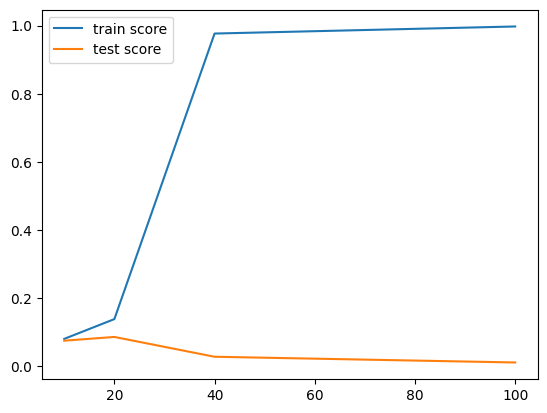

In [51]:
plt.plot(max_depths, train_scores, label='train score')
plt.plot(max_depths, test_scores, label='test score')
# Adding a legend
plt.legend()

# Display the plot
plt.show()

### Gradient Boosting Classifier

In [52]:
param_dist = {"gradientboostingclassifier__n_estimators": 50 * np.array([1, 2, 4]),
              "gradientboostingclassifier__max_depth": [3, 5, 10],
              "gradientboostingclassifier__learning_rate": [0.05, 0.1, 0.2]}
pipe = make_pipeline(ct, GradientBoostingClassifier())
random_search_gbclf = RandomizedSearchCV(pipe, param_dist, n_jobs=-1, n_iter=5, cv=2, scoring="f1", return_train_score=True)
random_search_gbclf.fit(X_train, y_train)


RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['availableMoney',
                                                                                'transactionAmount',
                                                                                'currentBalance']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer()),
                                                                                               ('stand...
                                                                                'currentExpDate',
                                                                                'dateOfLastAddressChange'])])),
                                             ('gradientboostingclassifier',
                                              GradientBoostingClassifier())]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'gradientboostingclassifier__learning_rate': [0.05,
                                                                                      0.1,
                                                                                      0.2],
                                        'gradientboostingclassifier__max_depth': [3,
                                                                                  5,
                                                                                  10],
                                        'gradientboostingclassifier__n_estimators': array([ 50, 100, 200])},
                   return_train_score=True, scoring='f1')

In [53]:
pd.DataFrame(random_search_gbclf.cv_results_)[["rank_test_score", 'mean_test_score', 'mean_train_score', 
                                         "param_gradientboostingclassifier__n_estimators", "param_gradientboostingclassifier__max_depth",
                                         "param_gradientboostingclassifier__learning_rate", 
                                         "mean_fit_time"]].sort_values("rank_test_score").set_index("rank_test_score")


,mean_test_score,mean_train_score,param_gradientboostingclassifier__n_estimators,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__learning_rate,mean_fit_time
rank_test_score,,,,,,
1,0.031956,0.978642,200,10,0.2,542.322935
2,0.022074,0.794403,200,10,0.1,656.632074
3,0.020048,0.536927,50,10,0.1,266.577447
4,0.007036,0.173201,50,10,0.05,283.431396
5,0.002193,0.020114,100,5,0.05,179.181308


In [54]:
create_conf_matrix(random_search_gbclf, X_train, y_train, X_test, y_test)

Train confusion matrix:


isFraud,False,True
prediction,,
False,619058,2116
True,91,7825


Train f1 score: 0.8764070112560901
----
Test confusion matrix:


isFraud,False,True
prediction,,
False,153425,2394
True,1372,82


Test f1 score: 0.04173027989821883


# Discussion

In our attempt to distinguish between fraud and non-fraud transactions in customer accounts, we experimented with three classification models: Logistic Regression, Random Forest Classifier, and Gradient Boost Classifier. However, we faced significant challenges in developing an effective model due to the extreme imbalance in our data.

1.   Data Preprocessing and EDA Analysis

Data Preprocessing is the critical step before feeding the data into machine learning model. Before processing data, Exploratory Data Analysis allow us to examine our features and choose the right methods to impute missing values, process numerical features and transform categorical features. Many columns have more than half of value counts as missing values so dropping these columns can enhance performance and prevent overfitting to ml models. Later, we applied one hot encoding to binary categorical features and label encoding to categorical featues with more than 2 values, preventing generating too many features and overfitting the ml models.

2. Imbalanced Data Hanlding
   Dealing imbalanced data can be a chanllenging problem as the number of non-fraudulent transactions far exceeds the number of fraudulent ones. Here are some strategies to handle imbalanced data in this context. Ml models ususally don't generalize well on imbalanced datasets. Balancing datasets before building ml models generally is consctructive in model learning. We used undersampling method to size down the majority class and created a balanced data for ml model buidling.
 

3.   Model Selection and Evaluation

In the modeling phase, we employed cross-validation on three different classification algorithms: Logistic Regression, Random Forest, and Gradient Boosting Classifier. Each model was strategically chosen to incrementally increase in complexity. This approach allows us to assess whether more complex models improve our ability to detect fraud in customer transactions compared to the initial Logistic Regression model.

* Logistic Regression:
We initiated with Logistic Regression due to its simplicity. However, being a linear model, it may struggle to capture non-linear relationships between features and the target variable.

* Random Forest:
Next, we elevated the complexity with the Random Forest Classifier. This ensemble method is capable of capturing non-linear patterns through the combination of multiple decision trees.

* Gradient Boosting Classifier:
The Gradient Boosting Classifier, chosen for its boosting technique, further increased model complexity. Boosting focuses on improving the weaknesses of previous models, potentially enhancing overall predictive performance.

* Logistic Regression Results:

We utilized Randomized Search to tune hyperparameters for Logistic Regression, including regularization strength (C) and solver options.
The balanced class weights were applied to address the imbalanced nature of the data.
However, Logistic Regression yielded limited success, as indicated by low f1 scores on both the training and test sets.
Logistic Regression exhibits limited ability to capture fraud instances, emphasizing the need for enhanced model complexity.

* Random Forest Results:

Randomized Search was similarly employed to optimize hyperparameters for the Random Forest Classifier, considering the number of estimators, maximum depth, and maximum features.
While the Random Forest Classifier exhibited an improvement in f1 scores compared to Logistic Regression, there is room for further enhancement.according to the results, our model is underfitting.

* Gradient Boosting Classifier Results:

We extended our exploration to the Gradient Boosting Classifier, adjusting hyperparameters such as the number of estimators, maximum depth, and learning rate.
The Gradient Boost Classifier shows promising results on the training set with a high f1 score of 0.872. However, its performance on the test set drops significantly (f1 score of 0.0386), indicating potential overfitting.

* conclusion:
  According to the results, we would prefer to choosing random forest model because it achieves the highest F1 score on test dataset. However it is still too low to apply.And for gradient boosting classifier, it achieves a good result on training data while a bad result on testing result, making it not a reliable model.

4. Possible Reasons for Our Model Results:
   
The extremely imbalanced nature of the data, where fraud instances are rare compared to non-fraud cases, posed a substantial challenge.
Imbalance can lead to models favoring the majority class, resulting in low sensitivity and f1 scores for the minority class (fraud).

5. Future Steps and Improvements:
   
In conclusion, our initial exploration indicates the need for further model refinement to effectively distinguish between fraud and non-fraud transactions. The suggestions outlined above aim to address current limitations and pave the way for improved fraud detection capabilities in our classification mode Other resampling methods can be tried:
Resampling Techniques: Oversampling the Minority Class: Increase the number of samples in the minority class (fraudulent transactions) by duplicating them or using techniques like SMOTE (Synthetic Minority Over-sampling Technique) which creates synthetic samples.


* Feature Engineering:

Consider incorporating frequency encoding to address the class imbalance. This technique assigns weights to different classes based on their frequency, potentially improving model performance.
Exploring New Features and Encoding Techniques:
In addition to the models and strategies discussed, we are planning to explore the implementation of frequency encoding, particularly focusing on the 'merchant_name' feature. This approach holds potential for being a significant predictor of fraud. Frequency encoding will involve assigning weights to merchant names based on their occurrence frequency, which could highlight repetitive fraudulent patterns associated with specific merchants. By integrating this technique, we aim to enhance the model's sensitivity towards subtle cues of fraud that might be overlooked by traditional methods. This addition is expected to provide a more nuanced understanding of the transactional data, thereby improving our model's capability to detect fraud more accurately and efficiently. The integration of such feature-specific techniques, combined with our existing models, could pave the way for a more robust and effective fraud detection system.


* Exploring New Features and Encoding Techniques:
In addition to the models and strategies discussed, we are planning to explore the implementation of frequency encoding, particularly focusing on the 'merchant_name' feature. This approach holds potential for being a significant predictor of fraud. Frequency encoding will involve assigning weights to merchant names based on their occurrence frequency, which could highlight repetitive fraudulent patterns associated with specific merchants. By integrating this technique, we aim to enhance the model's sensitivity towards subtle cues of fraud that might be overlooked by traditional methods. This addition is expected to provide a more nuanced understanding of the transactional data, thereby improving our model's capability to detect fraud more accurately and efficiently. The integration of such feature-specific techniques, combined with our existing models, could pave the way for a more robust and effective fraud detection system.
m.
   .

* Adjust Threshold:
We should vary the classification threshold. By default, many models use a threshold of 0.5 (probability greater than or equal to 0.5 for the positive class). We can experiment with thresholds like 0.4, 0.3, or others to observe how it affects the trade-off between precision and recall.

* Scoring Metrics Adjustment:

In light of our research question, where recall holds significance, it is advisable to prioritize its utilization for result analysis. However, acknowledging the potential escalation of false negatives, we must also account for precision. To strike a balance, we can assign different weights to these metrics in our scoring system. Experimenting with alternative scoring metrics, such as precision-recall curves or the area under the precision-recall curve, proves to be more fitting for imbalanced datasets.
i* Exploring Alternative Loss Functions for Imbalanced Fraud Detection:
In addressing the challenge of imbalanced datasets in fraud detection, it's crucial to consider the implementation of alternative loss functions tailored to this specific context. Loss functions such as 'Weighted Cross-Entropy' or 'Focal Loss' have shown promise in such scenarios. Weighted Cross-Entropy adjusts the loss based on the class frequencies, giving more weight to the minority class, thereby emphasizing the importance of correctly predicting fraud cases. Focal Loss, on the other hand, focuses on hard-to-classify examples and down-weighs the loss for well-classified cases, which can be particularly useful in distinguishing between fraud and non-fraud transactions. The choice of loss function significantly impacts the model's ability to learn from the underrepresented class and should be carefully selected based on the specific characteristics and requirements of the fraud detection task. Experimentation with these loss functions can lead to better handling of the imbalanced nature of fraud data, potentially enhancing the model's effectiveness in identifying fraudulent activities

* Adopting AUC-ROC Curve Metrics for Enhanced Model Selection:
In our ongoing efforts to refine our model selection process, we are considering the adoption of the AUC-ROC (Area Under the Receiver Operating Characteristics) curve metrics as a more comprehensive measure for evaluating our models. The AUC-ROC curve is particularly advantageous in imbalanced datasets like ours, as it provides a clear picture of how well the model distinguishes between the two classes (fraud and non-fraud) across different thresholds. Unlike the F1 score, which primarily focuses on the balance between precision and recall at a specific threshold, the AUC-ROC curve evaluates model performance over a range of threshold values, offering a more holistic view of its capability. This approach allows us to better understand the trade-offs between true positive rates and false positive rates, making it a crucial tool in the fine-tuning of our models for optimal fraud detection. By transitioning to AUC-ROC curve metrics, we aim to achieve a more nuanced and effective model evaluation, thereb

6. .
4Model Complexity and resource:

Explore more complex models or ensemble methods that can capture intricate patterns in the data. Deep learning approaches, such as neural networks, may be worth investing. However, resources should be prioritized when productionizing ml models.ransactions.

# References

Capital One. (2018). Capital One Data Science Challenge. In CapitalOneRecruiting GitHub Repository. https://github.com/CapitalOneRecruiting/DS

Python Software Foundation. Python Language Reference, version 3.11.6. Available at http://www.python.org

Timbers, T., Lee, M. & Ostblom, J. (2023). Breast Cancer Predictor. https://github.com/ttimbers/breast_cancer_predictor_py/tree/0.0.1

Pedregosa, F., Varoquaux, Ga"el, Gramfort, A., Michel, V., Thirion, B., Grisel, O., … others. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12(Oct), 2825–2830

McKinney, W., & others. (2010). Data structures for statistical computing in python. In Proceedings of the 9th Python in Science Conference (Vol. 445, pp. 51–56).

Caporal, J. (2023). Identity Theft and Credit Card Fraud Statistics for 2023. In the Ascent. https://www.fool.com/the-ascent/research/identity-theft-credit-card-fraud-statistics/